In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

# Math Stuff
import ee, scipy.misc, random, os
import numpy as np
from threading import Thread

# GEE stuff
from gee_library import *
ee.Initialize()

# debug stuff
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def tile_at(center_long_lat, meters, pixels, bands):
    """ Returns a (pixels, pixels, len(bands)) dimention numpy array of a 
    meters by meters section of earth centered at center_long_lat."""
    # Calculate resolution
    resolution = meters/pixels
    
    # Get GPS box
    tile_bounds = square_centered_at(
        point = center_long_lat,
        half_distance = meters
    )
    
    # load map
    monterey_collection = ee.ImageCollection('USDA/NAIP/DOQQ')\
        .filterBounds(tile_bounds)
#         .filter(ee.Filter.date('2016-01-01', '2017-01-01'))
        
    # request imagery
    tiles = img_at_region(monterey_collection, resolution, bands, tile_bounds)
    # resize img to requested size
    np_band_array = [scipy.misc.imresize(tiles[b], (pixels, pixels)) for b in bands]
    # and stack the images in a matrix
    return np.dstack(np_band_array)


def random_tile_within(coords, meters, pixels, bands):
    """ Chooses a random tile within the bounds of the coords.
    This function finds a random coordinate within the bounds defined by
    coords, then calls `tileat()` to grab that tile.
    
    `coords`: ((longmin, latmin),(longmax, latmax))
    
    Hits the server twice :/"""
    
    ((longmin, latmin),(longmax, latmax)) = coords
    
    # get random coords
    longitude = random.uniform(longmin, longmax)
    latitude = random.uniform(latmin, latmax)
    
    return tile_at((longitude, latitude), meters, pixels, bands)

def save_random_tile_at(coords, meters, pixels, bands, file_name):
    img = random_tile_within(coords, meters, pixels, bands)
    scipy.misc.toimage(img, cmin=0.0, cmax=-1).save(file_name)
    return
    

In [2]:
import time
from threading import Thread


# Define the bounds of each geographical area
# Cities
chicago = ((-87.769242, 41.663568), (-87.631913, 41.993581))
newyork = ((-73.995267, 40.596924), (-73.905278, 40.693623))
atlanta = ((-84.409626, 33.721386), (-84.356754, 33.774483))
sanfransisco = ((-122.448245, 37.740577), (-122.381984, 37.801367))
# Farmland
kansas = ((-99.647878, 38.457433), (-98.840109, 39.464683))
montana = ((-108.323227, 46.422764), (-106.332494, 47.224012))
georgia = ((-82.783325, 31.581322), (-82.492991, 31.813600))
# Mountains
sierranevadas = ((-122.533712, 43.170967), (-122.302144, 44.679019))
cascades = ((-121.640730, 47.486787), (-120.682082, 48.886281))
rockies = ((-106.577972, 38.700841), (-105.828700, 39.798840))

training_cities = [sanfransisco, atlanta, newyork]
test_city = [chicago]
training_mountains = [sierranevadas, rockies]
test_mountains=[cascades]
training_farms=[kansas, montana]
test_farms=[georgia]


# Define where we will save the data
DATA_DIR="./ch3_data"
TRAIN_IMG_DIR=os.path.join(DATA_DIR, "train_imgs")
TRAIN_IMG_LABELS=os.path.join(DATA_DIR, "train.txt")
TEST_IMG_DIR=os.path.join(DATA_DIR, "test_imgs")
TEST_IMG_LABELS=os.path.join(DATA_DIR, "test.txt")

# make directories if they don't exist
for d in [DATA_DIR, TRAIN_IMG_DIR, TEST_IMG_DIR]:
    if not os.path.exists(d):
        os.makedirs(d)


def download_data(gps_bound_list, number_of_examples, directory, delay=2.5):
    """ Downloads random tiles from a list of regions to `directory`.
    Spawns a thread for each image with a delay of `delay` seconds
    between thread spawns.
    
    Since each tile hits the server twice, and Google limits api requests
    to 3 per second, any value less than 1.5 will likely result in server
    errors."""
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for i in range(number_of_examples):
        if i%10 == 0:
            print i
        t = Thread(target=save_random_tile_at,
                   args=(random.choice(gps_bound_list),
                         100,
                         50,
                         ['R', 'G', 'B'],
                         os.path.join(directory, str(i)+'.png')))
        t.start()
        time.sleep(delay)
    

# #
# # Download training data
# #
# number_per_training_class = 1000
# print 'Grabbing training farms...'
# download_data(training_farms, number_per_training_class, os.path.join(TRAIN_IMG_DIR,'farms'))
# print 'Grabbing training cities...'
# download_data(training_cities, number_per_training_class, os.path.join(TRAIN_IMG_DIR,'cities'))
# print 'Grabbing training mountains...'
# download_data(training_mountains, number_per_training_class, os.path.join(TRAIN_IMG_DIR,'mountains'))
        


In [3]:
#
# Populate label files as comma-separated values (CSV)
#


with open(TRAIN_IMG_LABELS, "w") as myfile:
    klass = 0
    path = os.path.join(TRAIN_IMG_DIR,'farms')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
        
        
    klass = 1
    path = os.path.join(TRAIN_IMG_DIR,'cities')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")
        
    klass = 2
    path = os.path.join(TRAIN_IMG_DIR,'mountains')
    for f in os.listdir(path):
        filename = os.path.join(path, f)
        myfile.write(filename + "," + str(klass) + "\n")

In [4]:
import tensorflow as tf

#
# Create Data Reader
#

# Create a string-producer tensor to actually input the filename into the system
filename_queue = tf.train.string_input_producer([TRAIN_IMG_LABELS])

# Connect it to a line-reader tensor
reader = tf.TextLineReader()
key, value = reader.read(filename_queue)

# Connect that raw line-reader to a csv decoder
filename, labels = tf.decode_csv(value, record_defaults=[["error_filename"], ["error_label"]])

# Since the CSV has filenames in it, direct those filenames to another filereader (this time reads
# the whole file since they're png files)
file_contents = tf.read_file(filename)

# connect that file reader to a png decoder
png_data = tf.image.decode_png(file_contents, channels=3)
png_data_resized = tf.image.resize_images(png_data, (50, 50)) # Because we need to define an explicit size

# Since pngs are 8-bit integers, let's convert them to floats for the NN
features = tf.cast(png_data_resized, tf.float32)

# Now `features` is an image queue, and `label` is a label queue!

# Once you start training, don't forget to start up the queue!
# coord = tf.train.Coordinator()
# threads = tf.train.start_queue_runners(coord=coord)
# https://www.tensorflow.org/programmers_guide/reading_data

In [5]:
from scipy import misc

def gee_batch(batch_size):
    """Generates batches of size `batch_size`"""
    
    # read file
    lines = open(TRAIN_IMG_LABELS).read().splitlines()
    
    img_list = []
    label_list = []
    for i in range(batch_size):
        png_path, label = random.choice(lines).split(',')
        img_list.append(misc.imread(png_path).flatten())
#         img_list.append(np.zeros(50*50*3))
        one_hot = np.zeros(3)
        one_hot[int(label)] = 1
        label_list.append(one_hot)
        
    return np.stack(img_list, axis=0), np.stack(label_list, axis=0)

In [6]:
#
# Model
#


x = tf.placeholder(tf.float32, [None, 50*50*3])
y_ = tf.placeholder(tf.float32, [None, 3])



# Ensure our images are the correct shape
input_layer = tf.reshape(x, [-1, 50, 50, 3])


#
# Convolutions
#

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=input_layer,
    filters=32,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)

# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2 and Pooling Layer #2
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Convolutional Layer #3 (no pooling)
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=64,
    kernel_size=[3, 3],
    padding="valid",
    activation=tf.nn.relu)



#
# Fully Connected
#


# Dense Layer
conv3_flat = tf.reshape(conv3, [-1, 9 * 9 * 64])
dense = tf.layers.dense(inputs=conv3_flat, units=1024, activation=tf.nn.relu)
dropout = tf.layers.dropout(
    inputs=dense,
    rate=0.4,
    training= True)

# Logits Layer
logits = tf.layers.dense(inputs=dropout, units=3)



#
# Loss
#

# Turn our numerical labels into one-hot arrays
# onehot_labels = tf.one_hot(indices=tf.cast(y_, tf.int32), depth=3)
onehot_labels = y_

loss = None
train_op = None

loss = tf.losses.softmax_cross_entropy(
    onehot_labels=onehot_labels, # ground truth
    logits=logits) # network output




In [11]:
#
# Train
# 

# # optimizer
# optimizer = tf.contrib.layers.optimize_loss(
#     loss=loss,
#     global_step=tf.contrib.framework.get_global_step(),
#     learning_rate=0.001,
#     optimizer="SGD")

optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss)


correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize tensorflow
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


# And run 20k iterations
for i in range(20000):
    # make batch
    example_batch, label_batch = gee_batch(1)
    
    
    # Debug output
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:example_batch,
                                                 y_: label_batch})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    # run an iteration
    optimizer.run(feed_dict={x:example_batch,
                             y_: label_batch})

    
# Final accuracy
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


step 0, training accuracy 0
step 100, training accuracy 1
step 200, training accuracy 1


KeyboardInterrupt: 

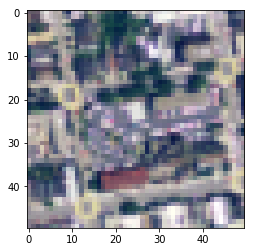

[[-5.35693073  7.40625763 -3.61006737]]


In [17]:
# Prediction

# farm, city, mountain

example_batch, label_batch = gee_batch(1)
   

predictions = sess.run(logits, feed_dict={x:example_batch, y_: label_batch})

img = example_batch.reshape((50,50,3))
plt.imshow(img); plt.show()

print "predictions:", predictions
print "ground truth:", label_batch


# BADLANDS

In [ ]:

# initialize interactive session
sess = tf.InteractiveSession()

# inputs ('None' refers to batch size)
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


#
# Helper functions for creating layers and initializing variables
#
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')


In [ ]:
##############
# First Layer
#

# make variables (5x5 kernel, 1 channel img, 32 filters)
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# reshape input (-1 is batch size)
x_image = tf.reshape(x, [-1,28,28,1])

# conv and pooling
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)



##############
# Second Layer
#

# make variables (32 channels coming in, 64 going out)
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# no reshaping of input necessary. input h_pool1 should have shape ...

# conv and pooling
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)




#######################
# Fully Connected Layer
#

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

# flatten convolution layer for FC operations
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


###########
# Dropout
#

keep_prob = tf.placeholder(tf.float32) # allows us to turn DO on and off during training and testing
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)


################
# Readout layer
#
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [ ]:
#
# Traning and testing
#

# loss
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# optimizer
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Initialize tensorflow
sess.run(tf.global_variables_initializer())

# And run 20k iterations
for i in range(20000):
    
    # make batch
    batch = mnist.train.next_batch(50)
    
    # Debug output
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
        
    # run an interation
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

    
# Final accuracy
print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))



# Basic Mnist version

In [ ]:
import tensorflow as tf

#
# Define Network
#

# A placeholder is a thing that *we* will be filling
x = tf.placeholder(tf.float32, [None, 784])

# A variable is a thing that we can fill and the network can also change
W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# prediction
y = tf.nn.softmax(tf.matmul(x, W) + b)

# ground truth
y_ = tf.placeholder(tf.float32, [None, 10])

# loss function
# cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

#
# Train
#

# Define optimizer
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# initialize session
sess = tf.InteractiveSession()

# initialize variables
tf.global_variables_initializer().run()

# train 1000 steps
for _ in range(1000):
  batch_xs, batch_ys = mnist.train.next_batch(100)
  sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    
#
# Evaluate
#

correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
